In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import api as pyq 

In [2]:
# Wavefunction generation
from scf_runs import run_lda_he, run_casci
scf_checkfile, opt_checkfile, mf_lda = run_lda_he()
ci_checkfile, mcc = run_casci(scf_checkfile, ncas = 1)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py
He atom neutral LDA spin=0
HF
converged SCF energy = -2.86151422722833  <S^2> = 2.4424907e-15  2S+1 = 1
LDA
converged SCF energy = -2.83456474290722  <S^2> = 3.1086245e-15  2S+1 = 1
CASCI nelecas up/down (1, 1)
CASCI E = -2.85953978800606  E(CI) = -2.85953978800606  S^2 = 0.0000000
Available output from CASCI: <KeysViewHDF5 ['ci', 'fci', 'mo_coeff', 'ncas', 'nelecas']>


In [3]:
import importlib, recipes
modules = [recipes]
for m in modules:
    importlib.reload(m)

    # Jastrow optimizationn
    
for fname in [opt_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)

# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
# bosonrecipes.ABOPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=2, nconfig=100, verbose=False)
recipes.OPTIMIZE(scf_checkfile, opt_checkfile, max_iterations=5, nconfig=1000, verbose=True)
# Jastrow optimization results
df = pyq.read_opt(opt_checkfile)
df

starting warmup
finished warmup
----------vmc done
Gradient norm:  0.6503081158140251
Dot product between gradient and SR step:  0.8787202317903298
descent en -2.8023020727199834 0.014215957090855047
energies from correlated sampling [-2.38266114 -2.61468992 -2.76098653 -2.84165607 -2.87320832]
----------vmc done
Gradient norm:  0.19390264572667065
Dot product between gradient and SR step:  0.9158617628361462
descent en -2.8785801540927105 0.012486638758591314
energies from correlated sampling [-2.84819587 -2.87648692 -2.90429309 -2.93154808 -2.95818622]
----------vmc done
Gradient norm:  0.05842390236376566
Dot product between gradient and SR step:  0.9171394138050537
descent en -2.9336229755104966 0.004368386330413228
energies from correlated sampling [-2.75190964 -2.74718459 -2.7420357  -2.73645636 -2.73043998]
----------vmc done
Gradient norm:  0.047308917037767906
Dot product between gradient and SR step:  0.9578958458023508
descent en -2.8698728528852335 0.014444114378946975
ener

,energy,iteration,error,fname
0,-2.802302,0,0.014216,he-sj.hdf5
1,-2.878580,1,0.012487,he-sj.hdf5
2,-2.933623,2,0.004368,he-sj.hdf5
3,-2.869873,3,0.014444,he-sj.hdf5
4,-2.905449,4,0.007941,he-sj.hdf5


In [4]:
tstep = 0.001
nconfig = 2000
nsteps = 1000
discard = 100
reblock_size = 50

In [5]:
import importlib, recipes
modules = [recipes] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools

def initialize_boson_qmc_objects_j(
    dft_checkfile,
):  
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    wf, to_opt = bosonwftools.generate_boson_wf(
        mol, mf, mc = mcc
    )
    load_parameters = opt_checkfile
    wftools.read_wf(wf, load_parameters)      
    return wf

def initialize_qmc_objects_j(
    dft_checkfile: str,
):
    mol, mf = pyscftools.recover_pyscf(dft_checkfile)
    wf, to_opt = wftools.generate_wf(
        mol, mf, mc = mcc
    )
    load_parameters = opt_checkfile
    wftools.read_wf(wf, load_parameters)      
    return wf

Text(0.5, 1.0, '100 trials')

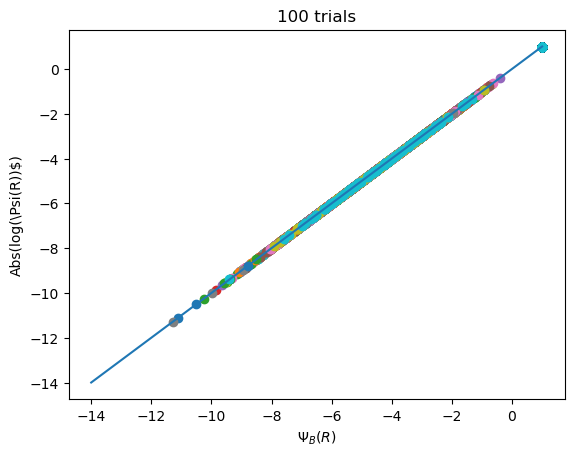

In [6]:
import importlib, bosonrecipes, mc, bosonwftools
modules = [bosonrecipes, mc, bosonwftools] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

import importlib, wftools
modules = [wftools] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
    
#phi and phib
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig)
    wfb = initialize_boson_qmc_objects_j(
        scf_checkfile,
    )
    wf = initialize_qmc_objects_j(
            scf_checkfile,
        )
    e=0
    sign, phi1 = wf.recompute(configs)
    g1, _, _ = wf.gradient_value(e, configs.electron(e))  
    phi1 = wf.value()
    # phi1a = saved['phi']
    e=0
    signb, phi2 = wfb.recompute(configs)
    g1b, _, _ = wfb.gradient_value(e, configs.electron(e))
    phi2 = wfb.value()
    plt.scatter(phi1, phi2)
x = np.linspace(-14, 1, 100)
plt.plot(x,x)
plt.xlabel(r'$\Psi_B(R)$')
plt.ylabel(r'Abs(log(\Psi(R))$)')
plt.title(str(trials) + ' trials')

Text(0.5, 1.0, '100 configurations')

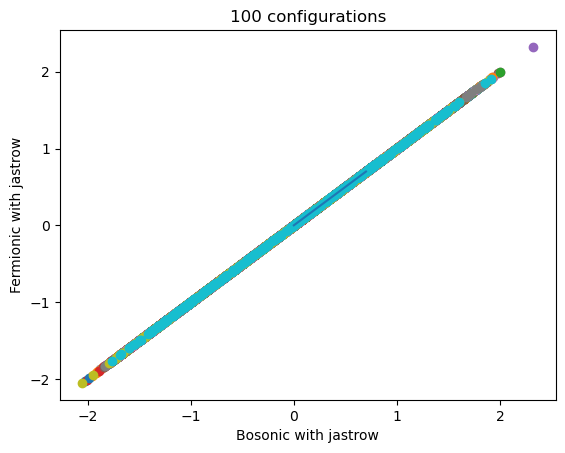

In [7]:
#Val and valb
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig)
    wfb = initialize_boson_qmc_objects_j(
        scf_checkfile,
    )
    wf = initialize_qmc_objects_j(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, _, _ = wf.gradient_value(e, configs.electron(e))  
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, _, _ = wfb.gradient_value(e, configs.electron(e))
    # valb2 = saved['psi']
    plt.scatter(g1, g1b)
x = np.linspace(0, 0.7, 100)
plt.plot(x,x)
plt.xlabel('Bosonic with jastrow')
plt.ylabel('Fermionic with jastrow')
plt.title(str(trials) + ' configurations')